C:\Users\timoz\AppData\Local\Temp\ipykernel_40872\947199019.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


New model created with the same architecture.
Selected features: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA for 5 days', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days', 'EMA for 5 days', 'EMA for 10 days', 'EMA for 20 days', 'EMA for 50 days', 'RSI_14']
Sequence length: 30
Microsoft data loaded: (2537, 6)
Data after preprocessing: (2488, 15)
All required features are present in the new dataset.
Prepared 2458 sequences
Starting training on Microsoft data...
Epoch [1/30] - Train Loss: 0.744797 - Val Loss: 0.026087 - LR: 0.001000
Epoch [2/30] - Train Loss: 0.015042 - Val Loss: 0.006523 - LR: 0.001000
Epoch [3/30] - Train Loss: 0.002457 - Val Loss: 0.006049 - LR: 0.001000
Epoch [4/30] - Train Loss: 0.001225 - Val Loss: 0.002450 - LR: 0.001000
Epoch [5/30] - Train Loss: 0.000636 - Val Loss: 0.001933 - LR: 0.001000
Epoch [6/30] - Train Loss: 0.000491 - Val Loss: 0.001606 - LR: 0.000500
Epoch [7/30] - Train Loss: 0.000453 - Val Loss: 0.001965 - LR: 0.000500
Epoch [8/30] - Train Loss

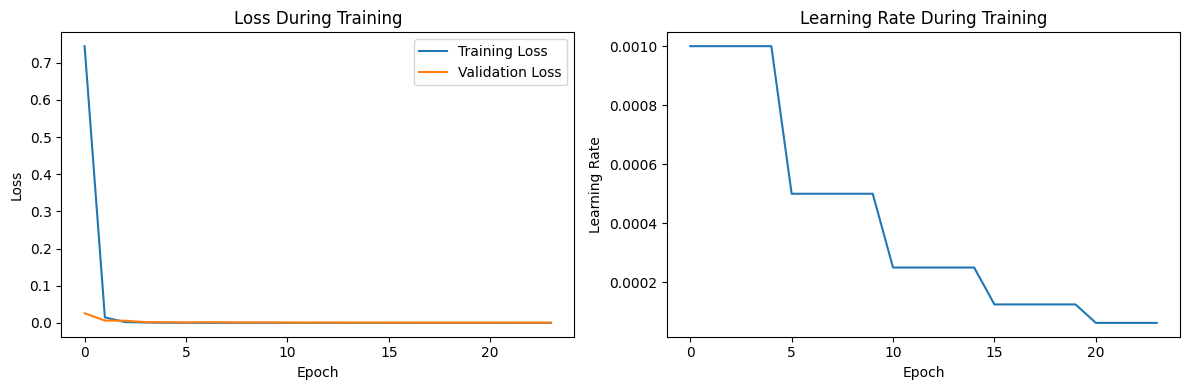

C:\Users\timoz\AppData\Local\Temp\ipykernel_40872\947199019.py:283: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_msft_model.pth'))


Loaded best model from training

Performance Metrics:
MSE: 108.917
RMSE: 10.436
MAE: 8.140
R2 Score: 0.948


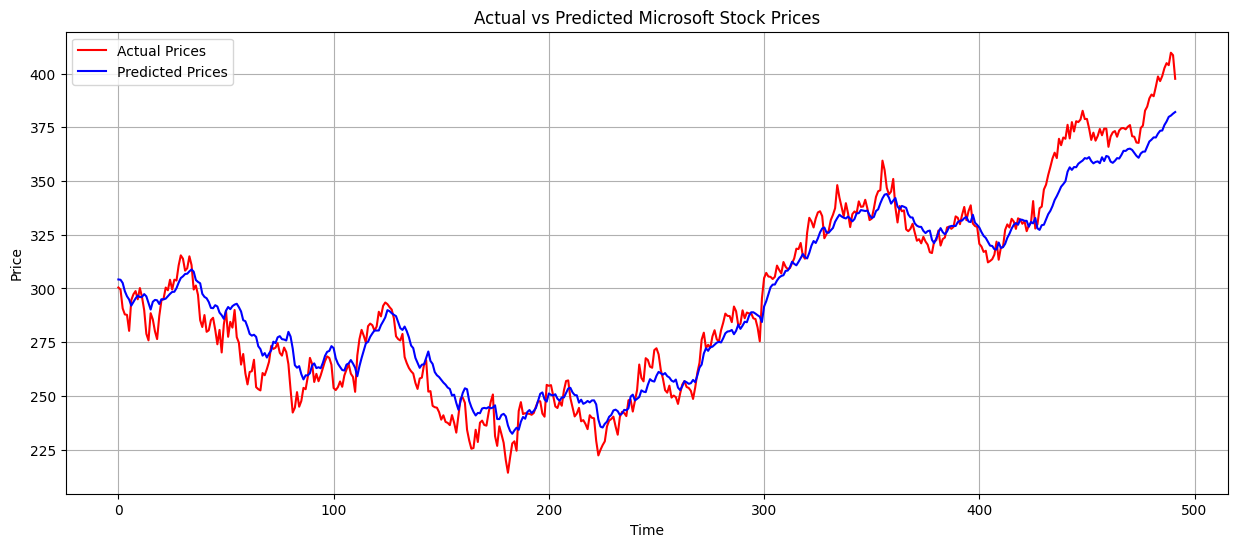

Microsoft model and preprocessing parameters saved to msft_predictor_complete.pth


In [ ]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define the model class (same as in your original code)
class StockPredictor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_encoder_layers=2, hidden_dim=64):
        super().__init__()
        
        # Input processing
        self.input_projection = nn.Linear(input_dim, d_model)
        self.input_norm = nn.LayerNorm(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,  
            dropout=0.1,
            batch_first=True,
            activation=F.gelu
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # Single-layer LSTM
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=1,  
            batch_first=True,
            bidirectional=True
        )
        
        # Output processing
        self.output_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # Input processing
        x = self.input_norm(self.input_projection(x))
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Take the last timestep
        x = lstm_out[:, -1, :]
        x = self.output_norm(x)
        x = self.fc(x)
        
        return x

# Define the RSI calculation function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Load the saved model to get architecture parameters
def load_model_architecture(path='stock_predictor_complete.pth'):
    checkpoint = torch.load(path)
    
    # Extract model parameters
    input_dim = checkpoint['input_dim']
    d_model = checkpoint['architecture']['d_model']
    nhead = checkpoint['architecture']['nhead']
    num_encoder_layers = checkpoint['architecture']['num_encoder_layers']
    hidden_dim = checkpoint['architecture']['hidden_dim']
    
    # Get other important parameters
    selected_features = checkpoint['selected_features']
    sequence_length = checkpoint['sequence_length']
    
    return input_dim, d_model, nhead, num_encoder_layers, hidden_dim, selected_features, sequence_length

# Load the model architecture parameters but NOT the weights
input_dim, d_model, nhead, num_encoder_layers, hidden_dim, selected_features, sequence_length = load_model_architecture('stock_predictor_complete.pth')

# Create a new model with the same architecture
model = StockPredictor(
    input_dim=input_dim, 
    d_model=d_model, 
    nhead=nhead, 
    num_encoder_layers=num_encoder_layers, 
    hidden_dim=hidden_dim
)

print("New model created with the same architecture.")
print(f"Selected features: {selected_features}")
print(f"Sequence length: {sequence_length}")

# Load Microsoft dataset
new_data = pd.read_csv('../datasets/MSFT.csv')
print(f"Microsoft data loaded: {new_data.shape}")

# Reset index
new_data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = new_data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
new_data[numeric_data.columns] = new_data[numeric_data.columns].fillna(numeric_data.mean())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Same as in original
for ma in ma_day:
    column_name = f"MA for {ma} days"
    new_data[column_name] = new_data['Close'].rolling(window=ma).mean()

# Calculate Exponential Moving Average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    new_data[column_name] = new_data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
new_data['RSI_14'] = calculate_rsi(new_data['Close'])

# Drop NaN values
new_data.dropna(inplace=True)
print(f"Data after preprocessing: {new_data.shape}")

# Check if all required features are present
missing_features = [feature for feature in selected_features if feature not in new_data.columns]
if missing_features:
    print(f"Warning: Missing features in new dataset: {missing_features}")
else:
    print("All required features are present in the new dataset.")

# Select the same features as in the original model
msft_features = new_data[selected_features]

# Create a new scaler specifically for Microsoft data
msft_scaler = MinMaxScaler()
scaled_features = msft_scaler.fit_transform(msft_features)

# Create sequences
X = []
y = []

for i in range(len(scaled_features) - sequence_length):
    X.append(scaled_features[i:(i + sequence_length)])
    y.append(scaled_features[i + sequence_length, 3])  # Using index 3 for Close price

X = torch.FloatTensor(np.array(X))
y = torch.FloatTensor(np.array(y))
print(f"Prepared {len(X)} sequences")

# Split into train and validation sets
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Create DataLoaders
batch_size = 128
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Define training function
def train_model(model, train_loader, val_loader, num_epochs=30):
    criterion = nn.MSELoss()  
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01
    )
    
    # step scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=5,
        gamma=0.5
    )
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    training_losses = []
    validation_losses = []
    
    # History dictionary to store metrics
    history = {
        'training_losses': [],
        'validation_losses': [],
        'learning_rates': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
        
        # Get current learning rate before stepping the scheduler
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        
        scheduler.step()
        
        avg_train_loss = total_train_loss / len(train_loader)
        history['training_losses'].append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        history['validation_losses'].append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {avg_train_loss:.6f} - '
              f'Val Loss: {avg_val_loss:.6f} - '
              f'LR: {current_lr:.6f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_msft_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
    
    return history

# Train the model on Microsoft data
print("Starting training on Microsoft data...")
history = train_model(model, train_loader, val_loader)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['training_losses'], label='Training Loss')
plt.plot(history['validation_losses'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['learning_rates'])
plt.title('Learning Rate During Training')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.tight_layout()
plt.show()

# Load the best model
model.load_state_dict(torch.load('best_msft_model.pth'))
print("Loaded best model from training")

# Make predictions
predictions = []
model.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert to numpy array and reshape
predictions = np.array(predictions).reshape(-1, 1)

# Create a full feature array with zeros
predictions_full = np.zeros((predictions.shape[0], len(selected_features)))

# Place predictions in the Close price position (index 3)
predictions_full[:, 3] = predictions.flatten()

# Inverse transform using the Microsoft scaler
predictions = msft_scaler.inverse_transform(predictions_full)[:, 3]

# Get actual Close prices
actual_scaled = np.zeros((len(y_val), len(selected_features)))
actual_scaled[:, 3] = y_val.numpy()
actual_prices = msft_scaler.inverse_transform(actual_scaled)[:, 3]

# Calculate metrics
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Microsoft Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Save the new model along with the Microsoft scaler
def save_model_complete(model, scaler, selected_features, sequence_length, path='msft_predictor_complete.pth'):
    d_model = model.input_projection.out_features
    nhead = model.transformer_encoder.layers[0].self_attn.num_heads
    num_encoder_layers = len(model.transformer_encoder.layers)
    hidden_dim = model.lstm.hidden_size
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': model.input_projection.in_features,
        'architecture': {
            'd_model': d_model,
            'nhead': nhead,
            'num_encoder_layers': num_encoder_layers,
            'hidden_dim': hidden_dim
        },
        'scaler': msft_scaler,  # Save the Microsoft-specific scaler
        'selected_features': selected_features,
        'sequence_length': sequence_length
    }, path)
    print(f"Microsoft model and preprocessing parameters saved to {path}")

# Save the Microsoft model
save_model_complete(model, msft_scaler, selected_features, sequence_length, path='msft_predictor_complete.pth')